Importing libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data


In [2]:
#operation data
data = pd.read_csv("/content/drive/MyDrive/bombing/THOR_Vietnam_Bombing_Operations.csv")
data.info()

/tmp/ipython-input-2-2212121390.py:2: DtypeWarning: Columns (3,13,18,19,20,22,26,27,29,30,32,35,44) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/bombing/THOR_Vietnam_Bombing_Operations.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4670416 entries, 0 to 4670415
Data columns (total 47 columns):
 #   Column                Dtype  
---  ------                -----  
 0   THOR_DATA_VIET_ID     int64  
 1   COUNTRYFLYINGMISSION  object 
 2   MILSERVICE            object 
 3   MSNDATE               object 
 4   SOURCEID              int64  
 5   SOURCERECORD          object 
 6   VALID_AIRCRAFT_ROOT   object 
 7   TAKEOFFLOCATION       object 
 8   TGTLATDD_DDD_WGS84    float64
 9   TGTLONDDD_DDD_WGS84   float64
 10  TGTTYPE               object 
 11  NUMWEAPONSDELIVERED   int64  
 12  TIMEONTARGET          float64
 13  WEAPONTYPE            object 
 14  WEAPONTYPECLASS       float64
 15  WEAPONTYPEWEIGHT      int64  
 16  AIRCRAFT_ORIGINAL     object 
 17  AIRCRAFT_ROOT         object 
 18  AIRFORCEGROUP         object 
 19  AIRFORCESQDN          object 
 20  CALLSIGN              object 
 21  FLTHOURS              int64  
 22  MFUNC                 object 
 23  MFUNC_D

In [3]:
#geo-spatial data
province_geo = gpd.read_file("/content/drive/MyDrive/bombing/DiaphanTinh/Dia_phan_Tinh.shp")
cambodia_geo = gpd.read_file("/content/drive/MyDrive/bombing/cambodia.json")
laos_geo = gpd.read_file("/content/drive/MyDrive/bombing/laos.json")
vietnam_geo = gpd.read_file("/content/drive/MyDrive/bombing/vietnam.json")
hcm_trail = gpd.read_file("/content/drive/MyDrive/bombing/ho_chi_minh_trail.geojson")

Simple Stat & Analysis

finding the bloodiest year


In [10]:
operation = data.copy()
#sorting out operations with coordinates
operation = operation[operation["TGTORIGCOORDS"].notna()][['WEAPONTYPEWEIGHT', 'TGTCOUNTRY','MSNDATE',
               'TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84','NUMWEAPONSDELIVERED']]

#total tonnage = bomb weight * number of bombs dropped
operation["Ton"] = operation["WEAPONTYPEWEIGHT"]*operation["NUMWEAPONSDELIVERED"]

#converting pounds to tons
operation["Ton"]=operation["Ton"]/2000

operation = operation.rename(columns = {"TGTLATDD_DDD_WGS84": "Lat", "TGTLONDDD_DDD_WGS84": "Lon"}).drop(columns=["WEAPONTYPEWEIGHT","NUMWEAPONSDELIVERED"]).reset_index(drop=True)
operation[:20]

,TGTCOUNTRY,MSNDATE,Lat,Lon,Ton
0,LAOS,1970-02-02,16.902500,106.014166,0.750
1,SOUTH VIETNAM,1970-10-08,14.945555,108.257222,0.000
2,LAOS,1970-11-25,19.602222,103.597222,1.500
3,LAOS,1972-03-08,14.573611,106.689722,0.000
4,LAOS,1971-05-12,17.563611,105.756666,2.776
5,LAOS,1971-12-19,16.864166,105.349166,0.000
6,NORTH VIETNAM,1972-10-15,18.842222,105.655000,0.000
7,SOUTH VIETNAM,1971-09-20,9.707500,104.881388,0.000
8,SOUTH VIETNAM,1972-04-26,14.620277,107.681944,0.000
9,NORTH VIETNAM,1972-08-24,18.606388,105.801111,0.000


In [11]:
#bloodiest year
operation["MSNDATE"] = pd.to_datetime(operation["MSNDATE"],format='mixed',errors='coerce')
operation ["Year"] = operation["MSNDATE"].dt.year
years = operation["Year"].unique().tolist()
ton=[]
for year in years:
  ton.append(operation[operation["Year"]==year]["Ton"].sum())
ton_by_year=pd.DataFrame(years,ton).reset_index(drop=False)
ton_by_year.columns=["Ton", "Year"]
ton_by_year.sort_values(by="Ton", ascending =False)

,Ton,Year
6,1.196574e+06,1968.0
5,1.096917e+06,1969.0
0,8.971983e+05,1970.0
1,8.686840e+05,1972.0
7,7.055565e+05,1967.0
2,5.364456e+05,1971.0
8,3.915817e+05,1966.0
3,2.973637e+05,1973.0
9,8.008462e+04,1965.0
4,2.282000e+00,1975.0


<BarContainer object of 11 artists>

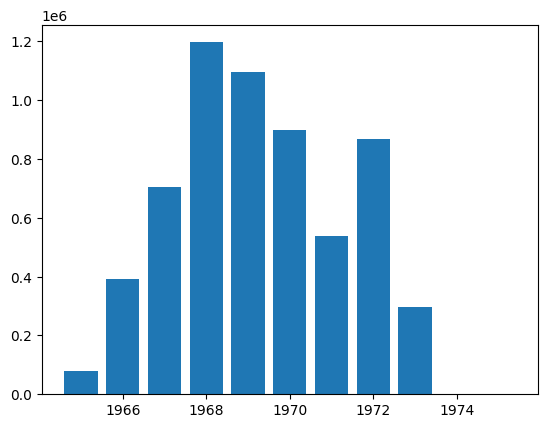

In [12]:
plt.bar(ton_by_year["Year"], ton_by_year["Ton"])

In [13]:
ton_by_year[ton_by_year["Year"]==1968.0]["Ton"]/(ton_by_year["Ton"].sum())
# the amount in 1968 alone accounts for nearly 20% of the total. making it the bloodiest year

,Ton
6,0.197116


Linebacker II

In [32]:
#linebacker 2 happened during Christmas 1972 in North Vietnam
operation["Month"] =  operation["MSNDATE"].dt.month
operation["Day"] =  operation["MSNDATE"].dt.day

linebacker2 = operation[(operation["Year"]==1972.0) & (operation["Month"] == 12.0) & (operation["TGTCOUNTRY"]=="NORTH VIETNAM")]
geometry = [Point(xy) for xy in zip(linebacker2["Lon"], linebacker2["Lat"])]

#converting current dataframe to geodataframe
dbp=gpd.GeoDataFrame(linebacker2[["Lat", "Lon", "Ton","Day"]], geometry=geometry, crs="EPSG:4326")

#appoint the operation to the provinces
linebacker2_geo = gpd.sjoin(dbp, province_geo, how="left", predicate="within")

In [40]:
#linebacker 2' purpose is to aim at major cities like hanoi and haiphong
main_city=linebacker2_geo[linebacker2_geo["Name"].isin(["Ha Noi", "Hai Phong"])]
ton=[]
for day in main_city["Day"].unique():
  ton.append(main_city[main_city["Day"]==day]["Ton"].sum())
x=pd.DataFrame(main_city["Day"].unique(), ton).reset_index(drop=False)
x.columns=["Ton", "Date"]
x=x.sort_values(by="Date", ascending=True)

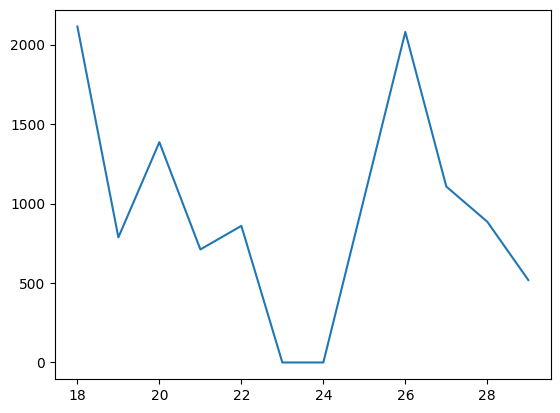

In [41]:
plt.plot(x["Date"], x["Ton"])

In [42]:
x["Ton"].sum()
#a total of 10,500 ton of bomb dropped in hanoi and haiphong during 11 days

np.float64(10447.826500000001)

Data for interactive map

In [46]:
geometry = [Point(xy) for xy in zip(operation["Lon"], operation["Lat"])]
operation_geo = gpd.GeoDataFrame(operation, geometry=geometry, crs="EPSG:4326")
operation_geo = operation_geo.drop(columns=["Lat", "Lon"])

#sorting out the operations in three Indochine countries
vietnam_operation = operation_geo[operation_geo["TGTCOUNTRY"].isin(["SOUTH VIETNAM", "NORTH VIETNAM"])]
laos_operation = operation_geo[operation_geo["TGTCOUNTRY"] == "LAOS"]
cambodia_operation = operation_geo[operation_geo["TGTCOUNTRY"] == "CAMBODIA"]

In [47]:
year= pd.to_datetime(vietnam_operation["MSNDATE"],format="ISO8601")
vietnam_operation["MSNDATE"] = year.dt.year

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
all = []
for i in range(1965,1976):
  ton=[]
  year=vietnam_operation[vietnam_operation["MSNDATE"]==i]
  joined = gpd.sjoin( year, province_geo, how="left", predicate="within")
  count = joined["Name"].value_counts()
  count = pd.DataFrame(count)
  count["year"] = i
  count = count.reset_index()
  count.columns = ["Province", "Count", "Year"]
  for j in count['Province'].to_list():
    ton.append(round(sum(joined[joined["Name"] == j]["Ton"]),2))
  count["Ton"] = ton
  count["Year"]=count["Year"].astype(int)
  all.append(count)
master_df = pd.concat(all, ignore_index=True)


In [ ]:
master_df.to_json("Operation_by_year.json")

Among top6 of the provinces, Quang Tri, Hue, Quang Nam, and Quang Binh are located in the central part, right next to the demarcation line, making this the most brutal war zome.

In [49]:
tonnage=[]
provinces= master_df["Province"].unique().tolist()
for province in provinces:
  tonnage.append(master_df[master_df["Province"]==province]["Ton"].sum())
pro = pd.DataFrame(provinces, tonnage)
pro=pro.reset_index(drop=False)
pro.columns = ["Ton", "Province"]
pro.sort_values(by="Ton",ascending=False)[:10]

,Ton,Province
23,718683.18,Quang Tri
15,299181.68,Kon Tum
26,292888.47,Thua Thien - Hue
13,285220.45,Tay Ninh
0,275012.31,Quang Nam
5,251046.23,Quang Binh
16,207916.73,Binh Phuoc
4,171079.89,Binh Duong
9,106687.20,Quang Ngai
1,97441.10,Gia Lai


In [51]:
central=pro[pro["Province"].isin(["Quang Tri", "Thua Thien - Hue", "Quang Binh", "Quang Nam"])]["Ton"].sum()
central/pro["Ton"].sum()
#these four provinces account for 42% of bombing tonnage of the whole country

np.float64(0.4232556306654697)

In [52]:
pro[pro["Province"]=="Quang Tri"]["Ton"]/pro["Ton"].sum(), pro[pro["Province"]=="Quang Tri"]["Ton"]/central
#quangtri make up to 1/5 of bombing tonnage for the entire coutry, 46% for the central area

(23    0.197828
 Name: Ton, dtype: float64,
 23    0.467397
 Name: Ton, dtype: float64)

Making the gif image for operation in Indochine

In [54]:
data = operation[(operation["Lon"] > 100) & (operation["Lon"] < 110) & (operation["Lat"] > 8) & (operation["Lat"] < 24)]
data = data[data["TGTCOUNTRY"].isin(["NORTH VIETNAM","SOUTH VIETNAM", "LAOS","CAMBODIA"])]
data["MSNDATE"] = pd.to_datetime(data["MSNDATE"])
data["Year"]=data["MSNDATE"].dt.year
year = data["Year"].unique().tolist()
year.pop(-1)


/tmp/ipython-input-54-3809656735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MSNDATE"] = pd.to_datetime(data["MSNDATE"])


nan

In [55]:
output_folder = "png"
os.makedirs(output_folder, exist_ok=True)

from shapely.geometry import Polygon, LineString
years = sorted(data["Year"].unique()) # Get unique years from your data
years.pop(-1)

# --- Determine consistent map limits (center point and zoom) ---
# Combine all geometries to find the overall bounds
all_geometries = gpd.GeoSeries(
    list(vietnam_geo.geometry) +
    list(laos_geo.geometry) +
    list(cambodia_geo.geometry) +
    list(hcm_trail.geometry)
)
minx, miny, maxx, maxy = all_geometries.total_bounds


# Add a buffer to the bounds for better margins around the map
buffer = 1.0 # Adjust buffer as needed
consistent_xlim = (minx - buffer, maxx + buffer)
consistent_ylim = (miny - buffer, maxy + buffer)

# --- End of consistent map limits calculation ---

# Loop through each year to create and save a plot
for i in years:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.set_xlim(consistent_xlim)
    ax.set_ylim(consistent_ylim)
    # Create a figure and axes for the plot
    # Set a larger figsize for better detail and a lighter background for the figure itself

    # Plot the country GeoDataFrames
    for j in [vietnam_geo, laos_geo, cambodia_geo]:
        j.plot(ax=ax,
               color="#D3D8E0", # Lighter, warmer color for land (e.g., light beige/cream)
               edgecolor="black", # Keep black edges for clear boundaries
               linewidth=0.05,
               zorder=1) # Slightly thinner linewidth for edges for less harsh look

    # Plot the Ho Chi Minh Trail
    hcm_trail.plot(ax=ax, color='#006400', linewidth=5,zorder=2)


    # Plot the data points for the current year
    ax.scatter(data[data["Year"]==i]["Lon"],
               data[data["Year"]==i]["Lat"],
               s=0.01,               # Significantly increase point size for visibility (from 0.1 to 20)
               c='red',         # Use a vibrant crimson red for the points
               alpha=0.7,          # Add transparency to show density if points overlap
               linewidth=0.5,
               zorder=3)          # Ensure points are drawn on top of map features

    # Set the title of the map
    plt.title(f"Bombing missions in the Vietnam War, year: {int(i)}", # Use f-string for clear title, convert year to int
              fontsize=13,                          # Larger font size for prominence
              color='#333333',                      # Dark grey color for title
              pad=20)                               # Add padding above the title
    for j in [vietnam_geo, laos_geo, cambodia_geo]:
        j.plot(ax=ax,
               facecolor='none',    # No fill color for this plot
               edgecolor="black",   # Explicitly set black edges for the borders
               linewidth=0.5,       # Keep desired border linewidth
               zorder=10)           # Very high zorder to ensure borders are on top of everything

    # Remove axis ticks and labels for a cleaner map appearance (good for maps)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


    # Save the plot as a PNG image with high DPI for quality
    plt.savefig(os.path.join(output_folder, f"{int(i)}.png"), dpi=300,bbox_inches='tight')

    # Close the figure to free up memory, especially in a loop
    plt.close(fig)

print("All aesthetic maps saved!")


All aesthetic maps saved!


In [56]:
from PIL import Image
import os

def create_gif_from_pngs(image_folder, output_gif_name="animation.gif", duration_ms=700, loop=0):
    """
    Creates a GIF from all PNG images in a specified folder.

    Args:
        image_folder (str): The path to the folder containing the PNG images.
        output_gif_name (str): The name of the output GIF file.
        duration_ms (int): The duration (in milliseconds) for each frame in the GIF.
        loop (int): How many times the animation should loop (0 means infinite loop).
    """
    images = []
    # Get all PNG files and sort them by name (important for correct sequence)
    # The filenames like 'indochina_map_1965.png', 'indochina_map_1966.png' will sort correctly
    png_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])


    for filename in png_files:
        file_path = os.path.join(image_folder, filename)
        images.append(Image.open(file_path))

    if images:
        # Save the first image, appending the rest as frames
        images[0].save(
            output_gif_name,
            save_all=True,
            append_images=images[1:],
            duration=duration_ms,
            loop=loop
        )
        print(f"GIF successfully created at '{output_gif_name}'")
    else:
        print("No images to create GIF.")


In [57]:
create_gif_from_pngs("/content/png")

GIF successfully created at 'animation.gif'
